# Tabular regression notebook

This notebook implements most of the computations for the tabular regression datasets, Concrete Strength and Energy Efficiency. It is organized into the following sections (sections in italics are not needed for the core results):
- [**Load and process data**](#Load-and-process-data)
- [*Use scikit-learn models for reference*](#Use-scikit-learn-models-for-reference) *(only for checking that MLP model is decent)*
- [**Train final model**](#Train-final-model)
- [*Re-train from scratch leaving out training samples*](#Re-train-from-scratch-leaving-out-training-samples) *(only for reproducing Figure 11 in the paper)*
- [**Further train to obtain gold-standard attribution values**](#Further-train-to-obtain-gold-standard-attribution-values): Not part of this notebook, please see and run the script 'further_train_regression.py'
- [**Run gradient-based TDA methods on final model**](#Run-gradient-based-TDA-methods-on-final-model): Grad-Dot, Grad-Cos, etc.
- [**Compare gradient-based methods with further training**](#Compare-gradient-based-methods-with-further-training): Produces the figures in the paper
- [*Compare gradient-based methods with re-training from scratch*](#Compare-gradient-based-methods-with-re-training-from-scratch) *(only for reproducing Figure 11 in the paper)*

## Import statements

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

In [2]:
# Data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Only needed for comparing with scikit-learn models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
# Training
from training import train_one_run, train_all_runs

In [4]:
# Gradient-based TDA methods
from torch.func import functional_call, grad, vmap
# DataInf
from collections import defaultdict
from time import time
from tqdm import tqdm
# torch-influence
from torch_influence import BaseObjective, CGInfluenceModule, LiSSAInfluenceModule

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cuda')

## Load and process data

### Load UCI Concrete Compressive Strength or Energy Efficiency dataset

**Instructions:** Download the data files from the UCI repository and place in a folder (such as the ones shown in the cell below).
- Concrete Compressive Strength: https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength
- Energy Efficiency: https://archive.ics.uci.edu/dataset/242/energy+efficiency

In [6]:
# dataset = "concrete"
dataset = "energy"

The following cell reads directly from the Excel files. For the Energy dataset, target variable Y2 is not used.

In [7]:
if dataset == "concrete":
    data = pd.read_excel(os.path.join("data", "concrete+compressive+strength", "Concrete_Data.xls"))
    # data = pd.read_csv(os.path.join("data", "concrete+compressive+strength", "Concrete_Data.csv"))
elif dataset == "energy":
    data = pd.read_excel(os.path.join("data", "energy-efficiency", "ENB2012_data.xlsx"))
    data.pop("Y2")

data

,X1,X2,X3,X4,X5,X6,X7,X8,Y1
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84
...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48


### Process dataset

Split into training and test

In [8]:
test_size = 0.1
seed = 0
data_train, data_test = train_test_split(data, test_size=test_size, random_state=seed)
print(data_train.shape, data_test.shape)

(691, 9) (77, 9)


Standardize data

In [9]:
scaler = StandardScaler()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)
print(data_train.mean(axis=0))
print(data_train.std(axis=0))

[-1.95373545e-16  5.55272181e-16 -1.18895085e-16 -7.19797272e-17
  2.05656363e-17  7.19797272e-17  1.20823114e-16 -7.19797272e-17
  1.49100864e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]


Split features and target

In [10]:
features_train, target_train = data_train[:, :-1], data_train[:, -1]
features_test, target_test = data_test[:, :-1], data_test[:, -1]
num_features = features_train.shape[1]
print(features_train.shape, target_train.shape)

(691, 8) (691,)


Convert to `TensorDataset`

In [11]:
dataset_train = TensorDataset(torch.from_numpy(features_train).float(), torch.from_numpy(target_train).float())
dataset_test = TensorDataset(torch.from_numpy(features_test).float(), torch.from_numpy(target_test).float())
dataset_train[0]

(tensor([ 0.2555, -0.4051,  0.5433, -0.6588,  1.0044,  1.3569,  0.1094,  1.4007]),
 tensor(1.6379))

Save processed datasets

In [151]:
os.makedirs(os.path.join("results", dataset), exist_ok=True)
torch.save(dataset_train, os.path.join("results", dataset, "dataset_train.pt"))
torch.save(dataset_test, os.path.join("results", dataset, "dataset_test.pt"))

Load processed datasets

In [12]:
dataset_train = torch.load(os.path.join("results", dataset, "dataset_train.pt"), weights_only=False)
dataset_test = torch.load(os.path.join("results", dataset, "dataset_test.pt"), weights_only=False)
num_features = dataset_train.tensors[0].shape[1]
num_features

8

Create `DataLoader`s

In [13]:
batch_size = 128    # same as in Bae et al., NeurIPS 2022

#dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
#dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, sampler=SequentialSampler(dataset_test))

[[back to top]](#Tabular-regression-notebook)

## Use scikit-learn models for reference

To ensure that MLP model is decent

In [14]:
reg = LinearRegression()

In [15]:
reg = GradientBoostingRegressor(n_estimators=500)

Fit on training data

In [16]:
reg.fit(features_train, target_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,500
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


Evaluate test MSE

In [17]:
pred = reg.predict(features_test)
mean_squared_error(target_test, pred)

0.0024084288603536453

[[back to top]](#Tabular-regression-notebook)

## Train final model

### Create MLP model

In [18]:
hidden_dim = 128    # same as in Bae et al., NeurIPS 2022

In [19]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
    def forward(self, x):
        return self.linear_relu_stack(x).squeeze(1)


Set random seed before initializing model

In [20]:
seed = 0
torch.manual_seed(seed)
model = MLP().to(device)

Save initial model

In [22]:
model_path = os.path.join("results", dataset, "model_initial.pth")
torch.save(model.state_dict(), model_path)

In [23]:
model = MLP().to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Train model

Set remaining training parameters

In [24]:
learning_rate = 3e-1    # tuned over [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1e0] to minimize test loss

In [25]:
loss_fn = nn.MSELoss()
loss_fn_per_sample = nn.MSELoss(reduction="none")
optimizer_class = torch.optim.SGD    # same as in Bae et al., NeurIPS 2022
# optimizer_class = torch.optim.Adam
num_epochs = 1000    # same as in Bae et al., NeurIPS 2022

Train starting from saved initial model and with specified random seed

In [26]:
seed = 0

In [166]:
test_loss_per_sample, model, params_dist = train_one_run(dataset_train, seed, batch_size, None, MLP, model_path, 
                                                         loss_fn, optimizer_class, learning_rate, num_epochs, dataloader_test, loss_fn_per_sample)

Final average training loss per sample: 0.0009007080322286735


Check test loss over last several epochs

In [167]:
test_loss_per_sample[-100:].mean(axis=1)

tensor([0.0026, 0.0024, 0.0025, 0.0027, 0.0025, 0.0026, 0.0028, 0.0036, 0.0043,
        0.0054, 0.0063, 0.0051, 0.0053, 0.0040, 0.0030, 0.0026, 0.0025, 0.0026,
        0.0026, 0.0026, 0.0025, 0.0028, 0.0026, 0.0026, 0.0034, 0.0027, 0.0027,
        0.0025, 0.0028, 0.0026, 0.0026, 0.0025, 0.0029, 0.0030, 0.0028, 0.0027,
        0.0028, 0.0027, 0.0027, 0.0025, 0.0025, 0.0025, 0.0025, 0.0027, 0.0025,
        0.0027, 0.0031, 0.0027, 0.0031, 0.0039, 0.0034, 0.0046, 0.0037, 0.0044,
        0.0044, 0.0037, 0.0028, 0.0039, 0.0039, 0.0031, 0.0026, 0.0026, 0.0031,
        0.0025, 0.0025, 0.0032, 0.0038, 0.0037, 0.0033, 0.0038, 0.0038, 0.0057,
        0.0066, 0.0056, 0.0058, 0.0039, 0.0040, 0.0024, 0.0026, 0.0026, 0.0027,
        0.0030, 0.0028, 0.0030, 0.0044, 0.0037, 0.0035, 0.0033, 0.0033, 0.0031,
        0.0027, 0.0024, 0.0026, 0.0027, 0.0026, 0.0025, 0.0028, 0.0025, 0.0030,
        0.0027], device='cuda:0')

Check test MSE

In [29]:
pred = model(dataset_test.tensors[0].to(device))
loss_fn(pred, dataset_test.tensors[1].to(device))

tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward0>)

### Save trained model

In [27]:
model_path = os.path.join("results", dataset, "model_final.pth")
torch.save(model.state_dict(), model_path)

In [28]:
model = MLP().to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

[[back to top]](#Tabular-regression-notebook)

## Re-train from scratch leaving out training samples

This section performs the leave-one-out re-training from scratch that is used to produce Figure 11 in the paper.

In [124]:
# Training data parameters
seeds = [seed]    # same random seed
if dataset == "concrete":
    indices_leave_out = range(0, 900, 9)
elif dataset == "energy":
    indices_leave_out = list(range(0, 700, 7))
    indices_leave_out[-1] = 690

In [125]:
# Model
model_class = MLP
model_path = os.path.join("results", dataset, "model_initial.pth")

Re-train on all leave-one-out datasets with same random seed and other hyperparameters

In [126]:
test_loss_retrain_full, test_loss_retrain_loo, params_dist_retrain_full, params_dist_retrain_loo =\
    train_all_runs(dataset_train, seeds, batch_size, indices_leave_out, model_class, model_path,
                   loss_fn, optimizer_class, learning_rate, num_epochs, dataloader_test, loss_fn_per_sample)

Using random seed 0
Training on full training set:
Final average training loss per sample: 0.03433152218349278
Training on leave-one-out datasets:


100it [13:42,  8.22s/it]


In [127]:
test_loss_retrain_full = test_loss_retrain_full.squeeze(3)
test_loss_retrain_loo = test_loss_retrain_loo.squeeze(3)
print(test_loss_retrain_full.shape)
print(test_loss_retrain_loo.shape)

torch.Size([500, 103, 1])
torch.Size([500, 103, 100])


In [82]:
torch.save(test_loss_retrain_full, os.path.join("results", dataset, "test_loss_retrain_full.pt"))
torch.save(test_loss_retrain_loo, os.path.join("results", dataset, "test_loss_retrain_loo.pt"))

[[back to top]](#Tabular-regression-notebook)

## Further train to obtain gold-standard attribution values

Please see and run the script 'further_train_regression.py'.

[[back to top]](#Tabular-regression-notebook)

## Run gradient-based TDA methods on final model

### Compute per-sample gradients of final model (for Grad-Dot, Grad-Cos, DataInf)

This section uses functions from `torch.func` to vectorize the gradient computation (but it is not clear that `torch.func` is significantly faster than a plain `torch` implementation).

Extract model parameters before calling model as a stateless function

In [30]:
params_detached = {k: v.detach() for k, v in model.named_parameters()}

Per-sample loss function for computing gradients

In [31]:
def compute_loss(params, features, target):
    batch = features.unsqueeze(0)
    targets = target.unsqueeze(0)
    
    prediction = functional_call(model, params, (batch,))
    loss = loss_fn(prediction, targets)
    return loss

Transform into function that computes per-sample gradient, then vectorize using `vmap`

In [32]:
compute_grad_vmap = vmap(grad(compute_loss), in_dims=(None, 0, 0))

Compute training and test gradients

In [33]:
grads_train = compute_grad_vmap(params_detached, dataset_train.tensors[0].to(device), dataset_train.tensors[1].to(device))
grads_test = compute_grad_vmap(params_detached, dataset_test.tensors[0].to(device), dataset_test.tensors[1].to(device))

for k, v in grads_train.items():
    print(k, v.shape)

linear_relu_stack.0.weight torch.Size([691, 128, 8])
linear_relu_stack.0.bias torch.Size([691, 128])
linear_relu_stack.2.weight torch.Size([691, 128, 128])
linear_relu_stack.2.bias torch.Size([691, 128])
linear_relu_stack.4.weight torch.Size([691, 1, 128])
linear_relu_stack.4.bias torch.Size([691, 1])


Check against plain PyTorch implementation from https://pytorch.org/functorch/stable/notebooks/per_sample_grads.html

In [34]:
def compute_grad(sample, target):
    
    sample = sample.unsqueeze(0)  # prepend batch dimension for processing
    target = target.unsqueeze(0)

    prediction = model(sample)
    loss = loss_fn(prediction, target)

    return torch.autograd.grad(loss, list(model.parameters()))

def compute_sample_grads(data, targets):
    """ manually process each sample with per sample gradient """
    sample_grads = [compute_grad(data[i], targets[i]) for i in range(len(targets))]
    sample_grads = zip(*sample_grads)
    sample_grads = [torch.stack(shards) for shards in sample_grads]
    return sample_grads


In [35]:
grads_train2 = compute_sample_grads(dataset_train.tensors[0].to(device), dataset_train.tensors[1].to(device))

In [36]:
for grads_layer, grads_layer2 in zip(grads_train.values(), grads_train2):
    print(torch.allclose(grads_layer, grads_layer2, atol=1e-5))

True
True
True
True
True
True


Compute damping strength recommended by Grosse et al. (2023) based on training gradient 2-norms

In [37]:
sum_of_squares = 0
num_elems = 0
for v in grads_train.values():
    sum_of_squares += (v ** 2).sum()
    num_elems += v.numel()

lamb = sum_of_squares / num_elems
lamb

tensor(1.6842e-06, device='cuda:0')

### Compute gradient similarity (Grad-Dot, Grad-Cos)

Compute all inner products between training gradients and test gradients

In [38]:
grad_dot = torch.zeros((len(dataset_test), len(dataset_train)), device=device)
grads_train_norm = torch.zeros(len(dataset_train), device=device)
grads_test_norm = torch.zeros(len(dataset_test), device=device)
# Iterate over model layers
for k, v in grads_train.items():
    # Inner product over all dimensions corresponding to parameters
    num_dims = v.dim()
    grad_dot += torch.tensordot(grads_test[k], grads_train[k], dims=(list(range(1, num_dims)),) * 2)
    grads_train_norm += (grads_train[k] ** 2).sum(dim=list(range(1, num_dims)))
    grads_test_norm += (grads_test[k] ** 2).sum(dim=list(range(1, num_dims)))
grads_train_norm = torch.sqrt(grads_train_norm)
grads_test_norm = torch.sqrt(grads_test_norm)

grad_dot

tensor([[ 1.2909e-05, -8.5171e-04,  3.4005e-03,  ..., -3.2208e-03,
          6.0691e-03,  1.1206e-03],
        [ 1.2492e-03, -1.2560e-03,  4.4695e-03,  ..., -4.1918e-03,
          1.0509e-02,  6.9641e-04],
        [ 3.4518e-02, -1.0732e-02,  1.8830e-03,  ..., -3.9990e-02,
          3.4097e-03,  6.2903e-03],
        ...,
        [-2.9451e-04,  1.4159e-04, -1.2191e-04,  ...,  5.7521e-04,
         -2.8606e-04, -8.6502e-05],
        [-1.4313e-02,  5.3347e-03, -1.5264e-03,  ...,  2.1280e-02,
         -5.1282e-03, -3.2119e-03],
        [ 3.5001e-03, -1.1997e-02,  3.8747e-04,  ..., -2.6685e-02,
          5.9250e-04,  2.4886e-03]], device='cuda:0')

Normalized inner products ("Grad-Cos")

In [39]:
grad_cos = grad_dot / grads_train_norm / grads_test_norm.unsqueeze(1)
grad_cos

tensor([[ 6.4424e-04, -5.9505e-02,  5.2099e-01,  ..., -8.7944e-02,
          4.6843e-01,  1.7996e-01],
        [ 4.9392e-02, -6.9517e-02,  5.4248e-01,  ..., -9.0677e-02,
          6.4258e-01,  8.8603e-02],
        [ 4.4652e-01, -1.9433e-01,  7.4774e-02,  ..., -2.8302e-01,
          6.8211e-02,  2.6183e-01],
        ...,
        [-7.8976e-02,  5.3153e-02, -1.0036e-01,  ...,  8.4392e-02,
         -1.1863e-01, -7.4644e-02],
        [-4.0390e-01,  2.1074e-01, -1.3223e-01,  ...,  3.2854e-01,
         -2.2380e-01, -2.9166e-01],
        [ 1.9805e-01, -9.5029e-01,  6.7303e-02,  ..., -8.2610e-01,
          5.1848e-02,  4.5312e-01]], device='cuda:0')

In [42]:
torch.save(grad_dot, os.path.join("results", dataset, "grad_dot.pt"))

In [43]:
torch.save(grad_cos, os.path.join("results", dataset, "grad_cos.pt"))

### DataInf

`IFEngineGeneration` class from https://github.com/ykwon0407/DataInf/blob/main/src/influence.py

In [40]:
class IFEngineGeneration(object):
    '''
    This class computes the influence function for every validation data point
    '''
    def __init__(self):
        self.time_dict = defaultdict(list)
        self.hvp_dict = defaultdict(list)
        self.IF_dict = defaultdict(list)

    def preprocess_gradients(self, tr_grad_dict, val_grad_dict):
        self.tr_grad_dict = tr_grad_dict
        self.val_grad_dict = val_grad_dict

        self.n_train = len(self.tr_grad_dict.keys())
        self.n_val = len(self.val_grad_dict.keys())

    def compute_hvp_proposed(self, lambda_const_param=10):
        start_time = time()
        hvp_proposed_dict=defaultdict(dict)
        for val_id in tqdm(self.val_grad_dict.keys()):
            for weight_name in self.val_grad_dict[val_id]:
                # lambda_const computation
                S=torch.zeros(len(self.tr_grad_dict.keys()))
                for tr_id in self.tr_grad_dict:
                    tmp_grad = self.tr_grad_dict[tr_id][weight_name]
                    S[tr_id]=torch.mean(tmp_grad**2)
                lambda_const = torch.mean(S) / lambda_const_param # layer-wise lambda
                if val_id == 0:
                    print(f"lambda for layer {weight_name} = {lambda_const}")

                # hvp computation
                hvp=torch.zeros(self.val_grad_dict[val_id][weight_name].shape, device=device)
                for tr_id in self.tr_grad_dict:
                    tmp_grad = self.tr_grad_dict[tr_id][weight_name]
                    C_tmp = torch.sum(self.val_grad_dict[val_id][weight_name] * tmp_grad) / (lambda_const + torch.sum(tmp_grad**2))
                    hvp += (self.val_grad_dict[val_id][weight_name] - C_tmp*tmp_grad) / (self.n_train*lambda_const)
                hvp_proposed_dict[val_id][weight_name] = hvp
        self.hvp_dict['proposed'] = hvp_proposed_dict
        self.time_dict['proposed'] = time()-start_time

    def compute_IF(self):
        for method_name in self.hvp_dict:
            print("Computing IF for method: ", method_name)
            if_tmp_dict = defaultdict(dict)
            for tr_id in self.tr_grad_dict:
                for val_id in self.val_grad_dict:
                    if_tmp_value = 0
                    for weight_name in self.val_grad_dict[0]:
                        if_tmp_value += torch.sum(self.hvp_dict[method_name][val_id][weight_name]*self.tr_grad_dict[tr_id][weight_name])
                    if_tmp_dict[tr_id][val_id]=-if_tmp_value

            self.IF_dict[method_name] = pd.DataFrame(if_tmp_dict, dtype=float)   


Convert training and test gradients to DataInf's dictionary format

In [41]:
grads_train_dict = {}
for i in range(len(dataset_train)):
    grads_train_dict[i] = {}
    for k in grads_train:
        grads_train_dict[i][k] = grads_train[k][i]

grads_test_dict = {}
for i in range(len(dataset_test)):
    grads_test_dict[i] = {}
    for k in grads_test:
        grads_test_dict[i][k] = grads_test[k][i]

In [42]:
for k, v in grads_train_dict[0].items():
    print(k, v.shape)

linear_relu_stack.0.weight torch.Size([128, 8])
linear_relu_stack.0.bias torch.Size([128])
linear_relu_stack.2.weight torch.Size([128, 128])
linear_relu_stack.2.bias torch.Size([128])
linear_relu_stack.4.weight torch.Size([1, 128])
linear_relu_stack.4.bias torch.Size([1])


Instantiate `IFEngineGeneration` object

In [43]:
IFengine = IFEngineGeneration()
IFengine.preprocess_gradients(grads_train_dict, grads_test_dict)

Compute DataInf influence values for multiple damping values

In [ ]:
lambda_const_params = [10, 1, 0.1, 0.01, 0.001]
num_lambdas = len(lambda_const_params)
datainf = torch.zeros((len(dataset_test), len(dataset_train), num_lambdas), device=device)

for l, lambda_const_param in enumerate(lambda_const_params):
    print(f"lambda_const_param = {lambda_const_param}")
    # Inverse-Hessian-vector product
    IFengine.compute_hvp_proposed(lambda_const_param=lambda_const_param)
    # Inner product between IHVP and training gradients 
    IFengine.compute_IF()
    # Convert and save influence values
    datainf[:, :, l] = torch.from_numpy(IFengine.IF_dict["proposed"].values).float().to(device)


In [64]:
torch.save(datainf, os.path.join("results", dataset, "datainf.pt"))

### torch-influence methods (CG, LiSSA, LiSSA-H)

Class that defines training and test losses

In [45]:
class MSEObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.mse_loss(outputs, batch[1])  # mean reduction required

    def train_regularization(self, params):
        return torch.tensor(0.)

    # training loss by default taken to be 
    # train_loss_on_outputs + train_regularization

    def test_loss(self, model, params, batch):
        return F.mse_loss(model(batch[0]), batch[1])  # no regularization in test loss

Instantiate influence modules

In [46]:
# Common parameters
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=SequentialSampler(dataset_train))
damp = 0.001
gnh = True
# gnh = False
# LiSSA parameters
repeat = 1
depth = 5000
scale = 10    # smallest in range [10, 20, 50, 100, 150, 200, 250, 300 400 500] for which algorithm converges

In [47]:
CG_module = CGInfluenceModule(model=model, objective=MSEObjective(), train_loader=dataloader_train, test_loader=dataloader_test, 
                                device=device, damp=damp, gnh=gnh)

In [48]:
LiSSA_module = LiSSAInfluenceModule(model=model, objective=MSEObjective(), train_loader=dataloader_train, test_loader=dataloader_test, 
                                   device=device, damp=damp, gnh=gnh, repeat=repeat, depth=depth, scale=scale)

Try different damping values (specifically multiples of the recommended value previously computed from gradient 2-norms)

In [49]:
if dataset == "concrete":
    lambda_scale = [0.1, 1, 10, 100]
elif dataset == "energy":
    lambda_scale = [1, 10, 100, 1000]
num_lambdas = len(lambda_scale)
torch.tensor(lambda_scale) * lamb.item()

tensor([1.6842e-06, 1.6842e-05, 1.6842e-04, 1.6842e-03])

Compute influence scores using CG (**NOTE:** CG may be particularly slow)

In [ ]:
cg = torch.zeros((len(dataset_test), len(dataset_train), num_lambdas), device=device)
for l in range(num_lambdas):
    # Set damping parameter to be multiple of recommended value previously computed
    CG_module.damp = lambda_scale[l] * lamb
    print(f"damp = {CG_module.damp}")
    for i in tqdm(range(len(dataset_test))):
        cg[i, :, l] = CG_module.influences(range(len(dataset_train)), [i])
        torch.save(cg, os.path.join("results", dataset, "cg.pt"))

**NOTE:** It seems that if `infl_module.influences()` throws an error, then `model.parameters()` becomes empty and the model has to be reloaded

Check that LiSSA converges

In [50]:
LiSSA_module.influences([1, 2, 3], [0])

tensor([ 1.1996e-06, -3.6823e-06, -5.2207e-06])

Compute influence scores using LiSSA

In [ ]:
lissa = torch.zeros((len(dataset_test), len(dataset_train), num_lambdas), device=device)
for l in range(num_lambdas):
    # Set damping parameter to be multiple of recommended value previously computed
    LiSSA_module.damp = lambda_scale[l] * lamb
    print(f"damp = {LiSSA_module.damp}")
    for i in tqdm(range(len(dataset_test))):
        lissa[i, :, l] = LiSSA_module.influences(range(len(dataset_train)), [i])
        torch.save(lissa, os.path.join("results", dataset, "lissa.pt"))

LiSSA without Gauss-Newton approximation and with largest damping value

In [62]:
LiSSA_module.gnh = False

In [ ]:
lissa_no_gnh = torch.zeros((len(dataset_test), len(dataset_train)), device=device)
for i in tqdm(range(len(dataset_test))):
    lissa_no_gnh[i, :] = LiSSA_module.influences(range(len(dataset_train)), [i])
    torch.save(lissa_no_gnh, os.path.join("results", dataset, "lissa_no_gnh.pt"))

[[back to top]](#Tabular-regression-notebook)

## Compare gradient-based methods with further training

### Load and process results

Load further training results

In [51]:
optimizer_name = "sgd"
subtract_mean = True

**NOTE:** If 'further_train_regression.py' was run multiple times on different ranges of seeds, you may have to load and concatenate all of them here.

In [52]:
seed_first, seed_last = 0, 100

test_loss_per_sample_full = torch.load(os.path.join("results", dataset, f"test_loss_further_train_{optimizer_name}_full_{seed_first}_{seed_last}.pt"), weights_only=True)
test_loss_per_sample_loo = torch.load(os.path.join("results", dataset, f"test_loss_further_train_{optimizer_name}_loo_{seed_first}_{seed_last}.pt"), weights_only=True)


Subtract loss due to further training on full training set. This implements eq. (17) in the paper.

In [53]:
test_loss_diff_loo = test_loss_per_sample_loo - test_loss_per_sample_full
num_epochs, num_test_eval, num_leave_out, num_seeds = test_loss_diff_loo.shape
test_loss_diff_loo.shape

torch.Size([500, 77, 100, 100])

Optionally subtract mean over left-out training instances. This implements eq. (13) in the paper. (It doesn't matter whether the previous cell was run first.)

In [54]:
if subtract_mean:
    test_loss_diff_loo -= test_loss_diff_loo.mean(dim=2, keepdim=True)

Load gradient-based attribution results

In [55]:
grad_dot = torch.load(os.path.join("results", dataset, "grad_dot.pt"), weights_only=True)
grad_cos = torch.load(os.path.join("results", dataset, "grad_cos.pt"), weights_only=True)
datainf = torch.load(os.path.join("results", dataset, "datainf.pt"), weights_only=True)
cg = torch.load(os.path.join("results", dataset, "cg.pt"), weights_only=True)
lissa = torch.load(os.path.join("results", dataset, "lissa.pt"), weights_only=True)
lissa_no_gnh = torch.load(os.path.join("results", dataset, "lissa_no_gnh.pt"), weights_only=True)

In [56]:
ekfac = torch.load(os.path.join("results", dataset, "ekfac.tensor"), weights_only=True).to(device)
ekfac.shape

torch.Size([77, 691])

In [57]:
#trak = np.load(os.path.join("results", dataset, "transposed_scores.np"))
trak = np.load(os.path.join("results", dataset, "transposed_scores_v2.np"))
trak = torch.from_numpy(trak).to(device)
trak.shape

torch.Size([77, 691])

### Compare with further training results averaged over random seeds

In [58]:
if dataset == "concrete":
    indices_leave_out = range(0, 900, 9)
elif dataset == "energy":
    indices_leave_out = list(range(0, 700, 7))
    indices_leave_out[-1] = 690

Initialize DataFrames with number of further training epochs as the index. The number of epochs quantifies the amount of further training and forms the x-axis in plots such as Figure 2(a)(b).

In [59]:
cos_sim_mean = pd.DataFrame(index=range(1, num_epochs + 1))
cos_sim_sem = pd.DataFrame(index=range(1, num_epochs + 1))

Compute cosine similarities between further training influence scores and gradient-based influence scores

In [60]:
cos_sim = F.cosine_similarity(test_loss_diff_loo.mean(dim=3), grad_dot[:, indices_leave_out].unsqueeze(0), dim=2)
cos_sim_mean["Grad-Dot"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["Grad-Dot"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [61]:
cos_sim = F.cosine_similarity(test_loss_diff_loo.mean(dim=3), grad_cos[:, indices_leave_out].unsqueeze(0), dim=2)
cos_sim_mean["Grad-Cos"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["Grad-Cos"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

For DataInf, CG, and LiSSA, select a damping value by specifying the index of the last dimension below

In [62]:
cos_sim = F.cosine_similarity(test_loss_diff_loo.mean(dim=3), -datainf[:, indices_leave_out, 0].unsqueeze(0), dim=2)
cos_sim_mean["DataInf"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["DataInf"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [63]:
cos_sim = F.cosine_similarity(test_loss_diff_loo.mean(dim=3), cg[:, indices_leave_out, 3].unsqueeze(0), dim=2)
cos_sim_mean["CG"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["CG"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [64]:
cos_sim = F.cosine_similarity(test_loss_diff_loo.mean(dim=3), lissa[:, indices_leave_out, 3].unsqueeze(0), dim=2)
cos_sim_mean["LiSSA"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["LiSSA"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [65]:
cos_sim = F.cosine_similarity(test_loss_diff_loo.mean(dim=3), lissa_no_gnh[:, indices_leave_out].unsqueeze(0), dim=2)
cos_sim_mean["LiSSA-H"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["LiSSA-H"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [66]:
cos_sim = F.cosine_similarity(test_loss_diff_loo.mean(dim=3), ekfac[:, indices_leave_out].unsqueeze(0), dim=2)
cos_sim_mean["EK-FAC"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["EK-FAC"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [67]:
cos_sim = F.cosine_similarity(test_loss_diff_loo.mean(dim=3), -trak[:, indices_leave_out].unsqueeze(0), dim=2)
cos_sim_mean["TRAK"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["TRAK"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)
cos_sim_mean

,Grad-Dot,Grad-Cos,DataInf,CG,LiSSA,LiSSA-H,EK-FAC,TRAK
1,0.704596,0.503132,0.702109,0.141178,0.155066,0.001103,0.252903,-0.000448
2,0.650158,0.463348,0.671855,0.150151,0.162831,0.010199,0.257917,-0.006869
3,0.605111,0.434781,0.645716,0.155009,0.169400,0.011732,0.263357,0.001162
4,0.566570,0.404922,0.619129,0.159098,0.173843,0.013920,0.263531,0.001744
5,0.550661,0.389762,0.606371,0.161840,0.176341,0.013107,0.263937,-0.001287
...,...,...,...,...,...,...,...,...
496,0.162361,0.105274,0.203624,0.356238,0.377778,0.032778,0.288631,0.007616
497,0.164540,0.107430,0.205149,0.355255,0.376904,0.033849,0.287846,0.007460
498,0.163640,0.106344,0.204574,0.355962,0.377518,0.033186,0.287803,0.007077
499,0.164010,0.106676,0.204634,0.356365,0.377864,0.033460,0.287973,0.007662


#### Plot

This corresponds to Figures 2(a)(b) in the paper if `subtract_mean == True`, to Figures 5(a)(b) if `subtract_mean == False`, and to Figures 4(a)(b) if `optimizer_name == "adam"` and `subtract_mean == True`.

In [68]:
fontsize = 16
subtract_string = "" if subtract_mean else "_subfull"

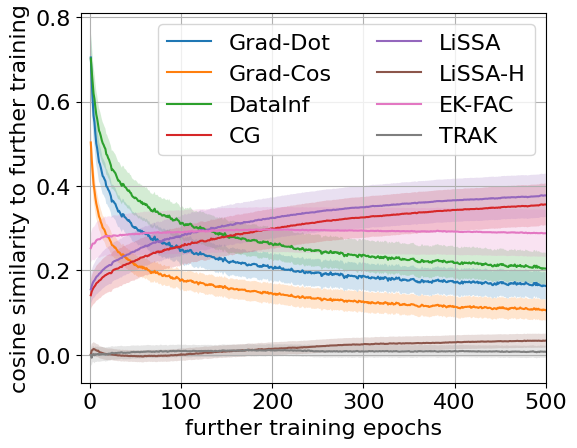

In [69]:
fig = plt.figure(figsize=(6., 4.8))
plt.plot(cos_sim_mean)
for method in cos_sim_mean.columns:
    plt.fill_between(cos_sim_mean.index, cos_sim_mean[method] - cos_sim_sem[method], cos_sim_mean[method] + cos_sim_sem[method], alpha=0.2)
plt.xlim(-10, num_epochs)
plt.grid()
plt.tick_params(labelsize=fontsize)
plt.xlabel("further training epochs", fontsize=fontsize)
plt.ylabel("cosine similarity to further training", fontsize=fontsize)
if dataset == "energy" and optimizer_name == "sgd" or dataset == "concrete" and optimizer_name == "adam":
    plt.legend(cos_sim_mean.columns, fontsize=fontsize, ncols=2)
#plt.savefig(os.path.join("figures", f"cos_sim_epochs_{optimizer_name}{subtract_string}_{dataset}.pdf"), bbox_inches="tight")

#### Spearman correlation instead of cosine similarity

This section is intended to reproduce Figures 6(a)(b) in the paper

In [70]:
from scipy.stats import spearmanr

In [71]:
spearman_mean = pd.DataFrame(index=range(1, num_epochs + 1))
spearman_sem = pd.DataFrame(index=range(1, num_epochs + 1))

In [72]:
test_loss_further_train_diff_mean = test_loss_diff_loo.mean(dim=3)
test_loss_further_train_diff_mean.shape

torch.Size([500, 77, 100])

In [73]:
spearman = np.zeros((num_epochs, num_test_eval))
for t in range(num_epochs):
    for i in range(num_test_eval):
        spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), grad_dot[i, indices_leave_out].cpu()).statistic
spearman_mean["Grad-Dot"] = spearman.mean(axis=1)
spearman_sem["Grad-Dot"] = spearman.std(axis=1) / np.sqrt(num_test_eval)

In [74]:
spearman = np.zeros((num_epochs, num_test_eval))
for t in range(num_epochs):
    for i in range(num_test_eval):
        spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), grad_cos[i, indices_leave_out].cpu()).statistic
spearman_mean["Grad-Cos"] = spearman.mean(axis=1)
spearman_sem["Grad-Cos"] = spearman.std(axis=1) / np.sqrt(num_test_eval)

In [75]:
spearman = np.zeros((num_epochs, num_test_eval))
for t in range(num_epochs):
    for i in range(num_test_eval):
        spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), -datainf[i, indices_leave_out, 0].cpu()).statistic
spearman_mean["DataInf"] = spearman.mean(axis=1)
spearman_sem["DataInf"] = spearman.std(axis=1) / np.sqrt(num_test_eval)

In [76]:
spearman = np.zeros((num_epochs, num_test_eval))
for t in range(num_epochs):
    for i in range(num_test_eval):
        spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), cg[i, indices_leave_out, 3].cpu()).statistic
spearman_mean["CG"] = spearman.mean(axis=1)
spearman_sem["CG"] = spearman.std(axis=1) / np.sqrt(num_test_eval)

In [77]:
spearman = np.zeros((num_epochs, num_test_eval))
for t in range(num_epochs):
    for i in range(num_test_eval):
        spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), lissa[i, indices_leave_out, 3].cpu()).statistic
spearman_mean["LiSSA"] = spearman.mean(axis=1)
spearman_sem["LiSSA"] = spearman.std(axis=1) / np.sqrt(num_test_eval)

In [78]:
spearman = np.zeros((num_epochs, num_test_eval))
for t in range(num_epochs):
    for i in range(num_test_eval):
        spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), lissa_no_gnh[i, indices_leave_out].cpu()).statistic
spearman_mean["LiSSA-H"] = spearman.mean(axis=1)
spearman_sem["LiSSA-H"] = spearman.std(axis=1) / np.sqrt(num_test_eval)

In [79]:
spearman = np.zeros((num_epochs, num_test_eval))
for t in range(num_epochs):
    for i in range(num_test_eval):
        spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), ekfac[i, indices_leave_out].cpu()).statistic
spearman_mean["EK-FAC"] = spearman.mean(axis=1)
spearman_sem["EK-FAC"] = spearman.std(axis=1) / np.sqrt(num_test_eval)

In [80]:
spearman = np.zeros((num_epochs, num_test_eval))
for t in range(num_epochs):
    for i in range(num_test_eval):
        spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), -trak[i, indices_leave_out].cpu()).statistic
spearman_mean["TRAK"] = spearman.mean(axis=1)
spearman_sem["TRAK"] = spearman.std(axis=1) / np.sqrt(num_test_eval)
spearman_mean

,Grad-Dot,Grad-Cos,DataInf,CG,LiSSA,LiSSA-H,EK-FAC,TRAK
1,0.704728,0.544245,0.550944,-0.003817,0.006999,-0.009165,0.056930,0.013945
2,0.552581,0.440858,0.488807,0.001508,0.007459,-0.000363,0.049889,-0.000945
3,0.415577,0.328163,0.408170,0.010940,0.014720,-0.001197,0.042750,-0.005842
4,0.322588,0.256148,0.351878,0.014938,0.015493,-0.003014,0.039140,-0.005251
5,0.264762,0.207117,0.300971,0.017123,0.014402,-0.007519,0.030533,-0.012675
...,...,...,...,...,...,...,...,...
496,0.000741,0.015878,-0.005961,0.162206,0.177182,0.023557,0.076479,-0.000670
497,0.003150,0.021092,-0.000344,0.160850,0.175548,0.026468,0.074408,-0.000873
498,-0.001029,0.017113,-0.007225,0.162979,0.177272,0.023984,0.076618,-0.001021
499,-0.000166,0.019448,-0.005475,0.161569,0.176548,0.024706,0.076500,0.001171


In [81]:
fontsize = 16
subtract_string = "" if subtract_mean else "_subfull"

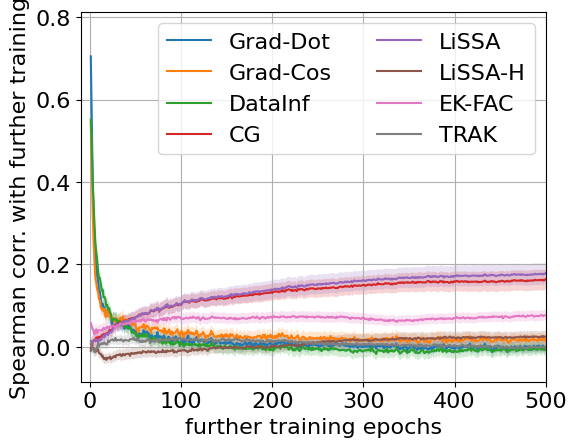

In [82]:
fig = plt.figure(figsize=(6., 4.8))
plt.plot(spearman_mean)
for method in spearman_mean.columns:
    plt.fill_between(spearman_mean.index, spearman_mean[method] - spearman_sem[method], spearman_mean[method] + spearman_sem[method], alpha=0.2)
plt.xlim(-10, num_epochs)
plt.grid()
plt.tick_params(labelsize=fontsize)
plt.xlabel("further training epochs", fontsize=fontsize)
plt.ylabel("Spearman corr. with further training", fontsize=fontsize)
if dataset == "energy" and optimizer_name == "sgd" or dataset == "concrete" and optimizer_name == "adam":
    plt.legend(cos_sim_mean.columns, fontsize=fontsize, ncols=2)
# plt.savefig(os.path.join("figures", f"spearman_epochs_{optimizer_name}{subtract_string}_{dataset}.pdf"), bbox_inches="tight")


### Average further training over different numbers of random seeds

This corresponds to Figures 7(a)(b) in the paper if `subtract_mean == True`, to Figures 9(a)(b) if `subtract_mean == False`, and to Figures 8(a)(b) if `optimizer_name == "adam"` and `subtract_mean == True`.

In [83]:
kernel_sizes = [1, 2, 5, 10, 20, 50, 100]
num_epochs_avg = 1

cos_sim = {}
#cos_sim_mean = torch.zeros(len(kernel_sizes))
cos_sim_mean = pd.DataFrame(index=kernel_sizes)
cos_sim_sem = pd.DataFrame(index=kernel_sizes)

for k, kernel_size in enumerate(kernel_sizes):
    # Average further training results over moving windows of random seeds
    test_loss_further_train_diff_avg = F.avg_pool1d(test_loss_diff_loo.view(-1, num_seeds), kernel_size=kernel_size).view(test_loss_diff_loo.shape[:3] + (-1,))
    # Compute cosine similarity
    cos_sim["Grad-Dot"] = F.cosine_similarity(test_loss_further_train_diff_avg, grad_dot[:,indices_leave_out].unsqueeze(0).unsqueeze(3), dim=2)
    cos_sim["Grad-Cos"] = F.cosine_similarity(test_loss_further_train_diff_avg, grad_cos[:,indices_leave_out].unsqueeze(0).unsqueeze(3), dim=2)
    cos_sim["DataInf"] = F.cosine_similarity(test_loss_further_train_diff_avg, -datainf[:,indices_leave_out,0].unsqueeze(0).unsqueeze(3), dim=2)
    cos_sim["CG"] = F.cosine_similarity(test_loss_further_train_diff_avg, cg[:,indices_leave_out,3].unsqueeze(0).unsqueeze(3), dim=2)
    cos_sim["LiSSA"] = F.cosine_similarity(test_loss_further_train_diff_avg, lissa[:,indices_leave_out,3].unsqueeze(0).unsqueeze(3), dim=2)
    cos_sim["LiSSA-H"] = F.cosine_similarity(test_loss_further_train_diff_avg, lissa_no_gnh[:,indices_leave_out].unsqueeze(0).unsqueeze(3), dim=2)
    cos_sim["EK-FAC"] = F.cosine_similarity(test_loss_further_train_diff_avg, ekfac[:,indices_leave_out].unsqueeze(0).unsqueeze(3), dim=2)
    cos_sim["TRAK"] = F.cosine_similarity(test_loss_further_train_diff_avg, -trak[:,indices_leave_out].unsqueeze(0).unsqueeze(3), dim=2)
    for key in cos_sim.keys():
        # Average over random seeds and test instances, take maximum over epochs
        cos_sim_mean.loc[kernel_size, key] = cos_sim[key].mean(dim=[1, 2]).max().item()
        step_max = cos_sim[key].mean(dim=[1, 2]).argmax()
        cos_sim_sem.loc[kernel_size, key] = cos_sim[key].std(dim=[1, 2])[step_max].item() / np.sqrt(cos_sim[key][0].numel())

cos_sim_mean
#print(cos_sim_sem)

,Grad-Dot,Grad-Cos,DataInf,CG,LiSSA,LiSSA-H,EK-FAC,TRAK
1,0.581160,0.419503,0.580103,0.349430,0.370260,0.032066,0.289158,0.010659
2,0.622512,0.446845,0.620524,0.352787,0.373881,0.032807,0.292686,0.011135
5,0.664754,0.476096,0.662635,0.355242,0.376615,0.033296,0.295918,0.011596
10,0.685265,0.490439,0.682950,0.355789,0.377198,0.033589,0.296856,0.011789
20,0.697689,0.498223,0.694976,0.356162,0.377629,0.033749,0.297467,0.011907
50,0.706783,0.504003,0.704161,0.356387,0.377890,0.033796,0.297697,0.011952
100,0.704596,0.503132,0.702109,0.356441,0.377955,0.033849,0.297695,0.011984


Text(0, 0.5, 'cosine similarity to further training')

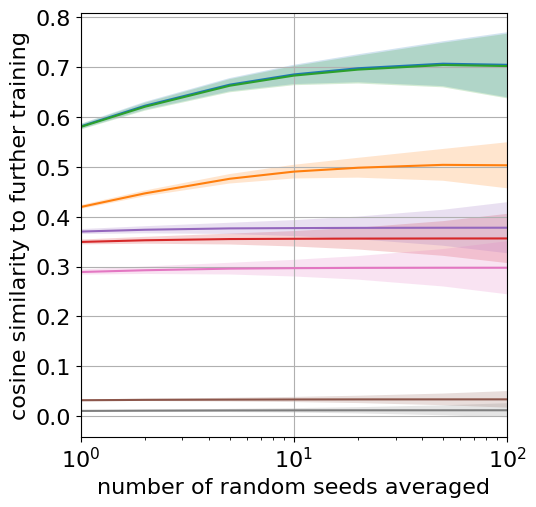

In [84]:
fig = plt.figure(figsize=(5.5, 5.5))
plt.semilogx(cos_sim_mean)
for method in cos_sim_mean.columns:
    plt.fill_between(cos_sim_mean.index, cos_sim_mean[method] - cos_sim_sem[method], cos_sim_mean[method] + cos_sim_sem[method], alpha=0.2)
plt.xlim(kernel_sizes[0], kernel_sizes[-1])
plt.grid()
plt.tick_params(labelsize=fontsize)
plt.xlabel("number of random seeds averaged", fontsize=fontsize)
plt.ylabel("cosine similarity to further training", fontsize=fontsize)
#fig.legend(cos_sim_mean.columns, fontsize=fontsize, loc="outside right")
# plt.savefig(os.path.join("figures", f"cos_sim_seeds_{optimizer_name}{subtract_string}_{dataset}.pdf"), bbox_inches="tight")


[[back to top]](#Tabular-regression-notebook)

## Compare gradient-based methods with re-training from scratch

This section is intended to reproduce Figure 11 in the paper.

In [230]:
subtract_mean = True

In [231]:
test_loss_retrain_full = torch.load(os.path.join("results", dataset, "test_loss_retrain_full.pt"), weights_only=True)
test_loss_retrain_loo = torch.load(os.path.join("results", dataset, "test_loss_retrain_loo.pt"), weights_only=True)

Subtract loss due to re-training on full training set

In [232]:
test_loss_retrain_diff = test_loss_retrain_loo - test_loss_retrain_full
num_epochs, num_test_eval, num_leave_out = test_loss_retrain_diff.shape
test_loss_retrain_diff.shape

torch.Size([1000, 77, 100])

Optionally subtract mean over left-out training instances

In [233]:
if subtract_mean:
    test_loss_retrain_diff -= test_loss_retrain_diff.mean(dim=2, keepdim=True)

In [234]:
if dataset == "concrete":
    indices_leave_out = range(0, 900, 9)
elif dataset == "energy":
    indices_leave_out = list(range(0, 700, 7))
    indices_leave_out[-1] = 690

In [235]:
cos_sim_mean = pd.DataFrame(index=range(1, num_epochs + 1))
cos_sim_sem = pd.DataFrame(index=range(1, num_epochs + 1))

In [236]:
cos_sim = F.cosine_similarity(test_loss_retrain_diff, grad_dot[:, indices_leave_out].unsqueeze(0), dim=2)
cos_sim_mean["Grad-Dot"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["Grad-Dot"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [237]:
cos_sim = F.cosine_similarity(test_loss_retrain_diff, grad_cos[:, indices_leave_out].unsqueeze(0), dim=2)
cos_sim_mean["Grad-Cos"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["Grad-Cos"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [238]:
cos_sim = F.cosine_similarity(test_loss_retrain_diff, -datainf[:, indices_leave_out, 0].unsqueeze(0), dim=2)
cos_sim_mean["DataInf"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["DataInf"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [239]:
cos_sim = F.cosine_similarity(test_loss_retrain_diff, cg[:, indices_leave_out, 3].unsqueeze(0), dim=2)
cos_sim_mean["CG"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["CG"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [240]:
cos_sim = F.cosine_similarity(test_loss_retrain_diff, lissa[:, indices_leave_out, 3].unsqueeze(0), dim=2)
cos_sim_mean["LiSSA"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["LiSSA"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [241]:
cos_sim = F.cosine_similarity(test_loss_retrain_diff, lissa_no_gnh[:, indices_leave_out].unsqueeze(0), dim=2)
cos_sim_mean["LiSSA-H"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["LiSSA-H"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [242]:
cos_sim = F.cosine_similarity(test_loss_retrain_diff, ekfac[:, indices_leave_out].unsqueeze(0), dim=2)
cos_sim_mean["EK-FAC"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["EK-FAC"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [243]:
cos_sim = F.cosine_similarity(test_loss_retrain_diff, -trak[:, indices_leave_out].unsqueeze(0), dim=2)
cos_sim_mean["TRAK"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["TRAK"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

#### Plot

In [244]:
fontsize = 16
subtract_string = "" if subtract_mean else "_subfull"

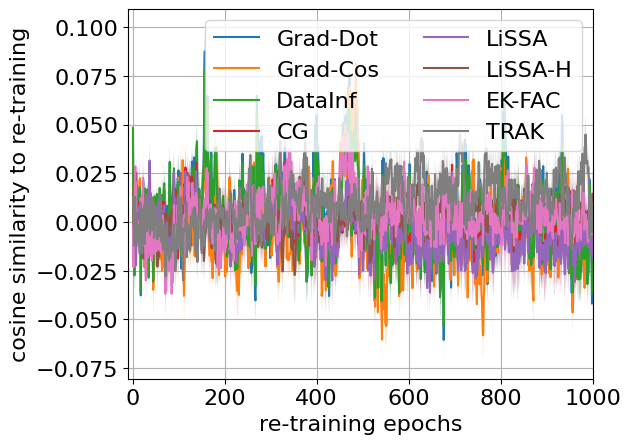

In [245]:
fig = plt.figure(figsize=(6., 4.8))
plt.plot(cos_sim_mean)
for method in cos_sim_mean.columns:
    plt.fill_between(cos_sim_mean.index, cos_sim_mean[method] - cos_sim_sem[method], cos_sim_mean[method] + cos_sim_sem[method], alpha=0.2)
plt.xlim(-10, num_epochs)
plt.grid()
plt.tick_params(labelsize=fontsize)
plt.xlabel("re-training epochs", fontsize=fontsize)
plt.ylabel("cosine similarity to re-training", fontsize=fontsize)
plt.legend(cos_sim_mean.columns, fontsize=fontsize, ncols=2)
# plt.savefig(os.path.join("figures", f"cos_sim_epochs_re-train{subtract_string}_{dataset}.pdf"), bbox_inches="tight")

[[back to top]](#Tabular-regression-notebook)